In [ ]:
from HierarchicalViT.data.load_cifrar import *

In [ ]:
train_loader, val_loader, test_loader = get_cifar100_dataloaders(
    batch_size=128,
    data_dir="./data/cifar100",
    num_workers=2,
    val_split=0.1)

In [ ]:

CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

images, labels = next(iter(train_loader))

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Images dtype: {images.dtype}, Labels dtype: {labels.dtype}")

Images shape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])
Images dtype: torch.float32, Labels dtype: torch.int64


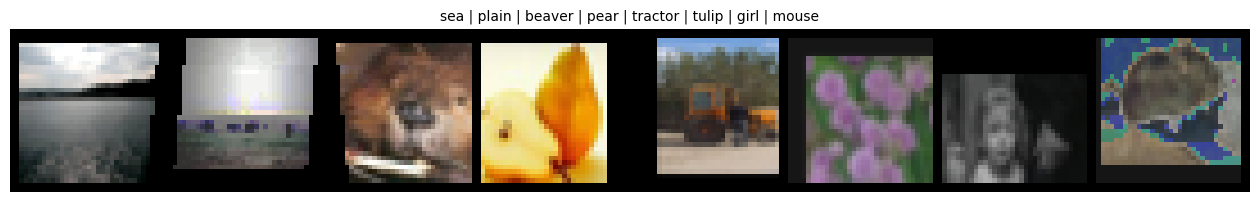

In [ ]:
from data.data_utils import *


cifar100_train = datasets.CIFAR100(
    root="./data/cifar100",
    train=True,
    download=False)
class_names = cifar100_train.classes

show_batch(images, labels, class_names=class_names, n=8)

---

# Model

In [ ]:
from model.patch_embedding import *

patch_embed = PatchEmbeddingConv(
    img_size=32,
    patch_size=4,
    in_chans=3,
    embed_dim=192,
    norm_layer=nn.LayerNorm)

tokens, (Hp, Wp) = patch_embed(images)

print("Tokens shape:", tokens.shape)
print("Grid size:", Hp, Wp)

Tokens shape: torch.Size([128, 64, 192])
Grid size: 8 8


In [ ]:
from model.attention_blocks import *

images, labels = next(iter(train_loader))
print("Input images:", images.shape)

patch_embed = PatchEmbeddingConv(
    img_size=32,
    patch_size=4,       # 32 / 4 = 8 → 8x8 = 64 tokens
    in_chans=3,
    embed_dim=192,
    norm_layer=nn.LayerNorm)

tokens, (Hp, Wp) = patch_embed(images)
print("After PatchEmbeddingConv -> tokens:", tokens.shape)
print("Grid size:", Hp, Wp)

block = TransformerBlock(
    dim=192,
    num_heads=3,
    mlp_ratio=4.0,
    attn_dropout=0.0,
    dropout=0.1)

out = block(tokens)
print("After TransformerBlock:", out.shape)

assert out.shape == tokens.shape
print("Todo OK: el bloque preserva [B, N, D].")


Input images: torch.Size([128, 3, 32, 32])
After PatchEmbeddingConv -> tokens: torch.Size([128, 64, 192])
Grid size: 8 8
After TransformerBlock: torch.Size([128, 64, 192])
Todo OK: el bloque preserva [B, N, D].


In [ ]:
from model.transformer_pooling import *

tokens1, grid1 = patch_embed(images)
print("Stage 1 tokens:", tokens1.shape, "grid:", grid1)

pool1 = PoolingLayer(
    dim_in=192,
    dim_out=384,
    kernel_size=3,
    stride=2,
    norm_layer=nn.LayerNorm)

tokens2, grid2 = pool1(tokens1, grid1)

print("After Pooling 1 -> tokens2:", tokens2.shape, "grid2:", grid2)

B = images.size(0)
assert tokens2.shape == (B, 4*4, 384)
assert grid2 == (4, 4)
print("PoolingLayer OK")

Stage 1 tokens: torch.Size([128, 64, 192]) grid: (8, 8)
After Pooling 1 -> tokens2: torch.Size([128, 16, 384]) grid2: (4, 4)
PoolingLayer OK


In [ ]:
from model.hierarchical_vit import *

model = HierarchicalViT(
    img_size=32,
    patch_size=4,
    in_chans=3,
    num_classes=100,
    embed_dims=(192, 384, 576),
    depths=(2, 2, 4),
    num_heads=(3, 6, 9),
    mlp_ratio=4.0,
    attn_dropout=0.0,
    dropout=0.1)

out = model(images)

print("Input:", images.shape)
print("Output logits:", out.shape)

Input: torch.Size([128, 3, 32, 32])
Output logits: torch.Size([128, 100])


---

# Training

---

In [ ]:
from training.train_vit import *

device = "cuda" if torch.cuda.is_available() else "cpu"

model = HierarchicalViT(
    img_size=32,
    patch_size=4,
    in_chans=3,
    num_classes=100,
    embed_dims=(192, 384, 576),
    depths=(2, 2, 4),
    num_heads=(3, 6, 9),
    mlp_ratio=4.0,
    attn_dropout=0.0,
    dropout=0.2)


history = train_vit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=50,
    device=device,
    lr=3e-4,
    weight_decay=1e-4,
    autocast_dtype="fp16",
    use_amp=True,
    use_grad_scaler=True,
    save_best=True,
    save_path="best_hvit_cifar100.pth",
    scheduler=None,
    print_every=100)



=== Epoch 1/50 ===
[Step 100/352] Loss: 4.4450 | Top-1: 3.56% | Top-3: 8.88% | Top-5: 13.65%
[Step 200/352] Loss: 4.3252 | Top-1: 4.70% | Top-3: 11.61% | Top-5: 17.33%
[Step 300/352] Loss: 4.2405 | Top-1: 5.53% | Top-3: 13.53% | Top-5: 19.79%
[Train] Loss: 4.1979 | Top-1: 5.96% | Top-3: 14.44% | Top-5: 21.02%
[Val]   Loss: 3.9039 | Top-1: 9.44% | Top-3: 21.62% | Top-5: 29.42%
Nuevo mejor modelo guardado en best_hvit_cifar100.pth (Val Top-1 = 9.44%)

=== Epoch 2/50 ===
[Step 100/352] Loss: 3.8753 | Top-1: 10.12% | Top-3: 22.31% | Top-5: 30.81%
[Step 200/352] Loss: 3.8235 | Top-1: 11.15% | Top-3: 23.95% | Top-5: 32.68%
[Step 300/352] Loss: 3.7821 | Top-1: 11.62% | Top-3: 24.88% | Top-5: 33.99%
[Train] Loss: 3.7594 | Top-1: 12.00% | Top-3: 25.54% | Top-5: 34.74%
[Val]   Loss: 3.6222 | Top-1: 13.84% | Top-3: 29.42% | Top-5: 39.32%
Nuevo mejor modelo guardado en best_hvit_cifar100.pth (Val Top-1 = 13.84%)

=== Epoch 3/50 ===
[Step 100/352] Loss: 3.5500 | Top-1: 15.17% | Top-3: 31.02% | Top

---

# Experiments

In [ ]:
from validation.test_model import *

test_loss, test_metrics = test_model(
    model=HierarchicalViT(
    img_size=32,
    patch_size=4,
    in_chans=3,
    num_classes=100,
    embed_dims=(192, 384, 576),
    depths=(2, 2, 4),
    num_heads=(3, 6, 9),
    mlp_ratio=4.0,
    attn_dropout=0.0,
    dropout=0.1,),
    checkpoint_path="best_hvit_cifar100.pth",
    test_loader=test_loader,
    device=device,
    autocast_dtype="fp16",
    use_amp=True)

[Test] Loss: 1.7671 | Top-1: 57.46% | Top-3: 76.58% | Top-5: 82.99%


In [ ]:
from validation.top_accuracy_clases import *

logits_test, targets_test, preds_test = collect_predictions(
    model,
    test_loader,
    device=device,
    autocast_dtype="fp16",
    use_amp=True)

num_classes = 100
acc_pc, counts = per_class_accuracy(preds_test, targets_test, num_classes)

from torchvision import datasets
cifar100_train = datasets.CIFAR100(root="./data/cifar100", train=True, download=False)
class_names = cifar100_train.classes

print_best_and_worst_classes(acc_pc, counts, class_names, k=20)


Clases más difíciles:
            squirrel | acc=25.00% | n=100
                 man | acc=26.00% | n=100
              lizard | acc=27.00% | n=100
                girl | acc=27.00% | n=100
                seal | acc=30.00% | n=100
                bear | acc=31.00% | n=100
                bowl | acc=32.00% | n=100
               woman | acc=32.00% | n=100
               otter | acc=33.00% | n=100
              possum | acc=34.00% | n=100
              rabbit | acc=35.00% | n=100
                 boy | acc=36.00% | n=100
              turtle | acc=38.00% | n=100
               snake | acc=38.00% | n=100
               mouse | acc=38.00% | n=100
             raccoon | acc=39.00% | n=100
               snail | acc=39.00% | n=100
               couch | acc=41.00% | n=100
               shark | acc=41.00% | n=100
           crocodile | acc=42.00% | n=100

Clases más fáciles:
                road | acc=90.00% | n=100
          motorcycle | acc=90.00% | n=100
            wardrobe | acc=89.00

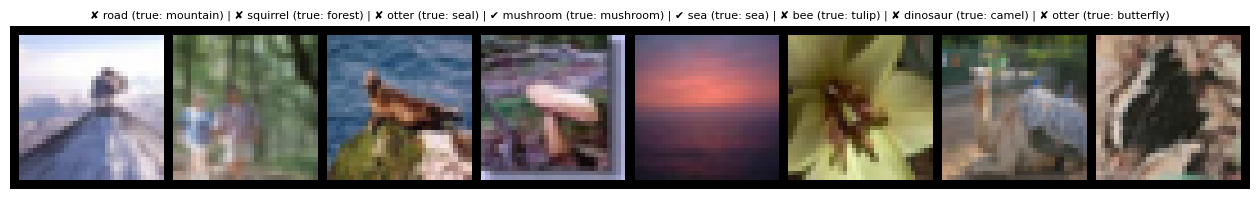

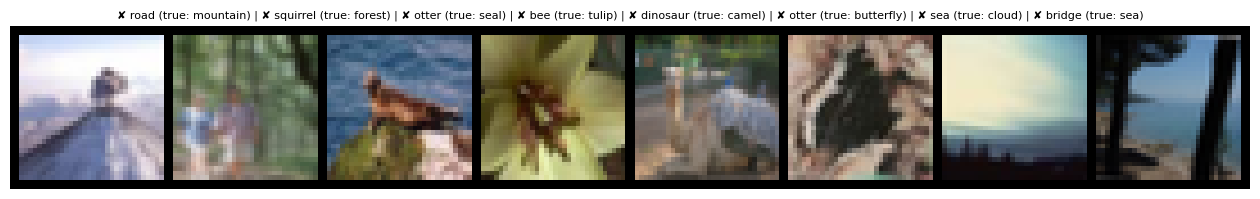

In [ ]:
from validation.show_predictions import *


show_predictions_grid(
    model,
    test_loader,
    class_names=class_names,
    device=device,
    autocast_dtype="fp16",
    use_amp=True,
    n=8,
    only_misclassified=False,)

show_predictions_grid(
    model,
    test_loader,
    class_names=class_names,
    device=device,
    autocast_dtype="fp16",
    use_amp=True,
    n=8,
    only_misclassified=True,)

t-SNE sobre 1034 puntos...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


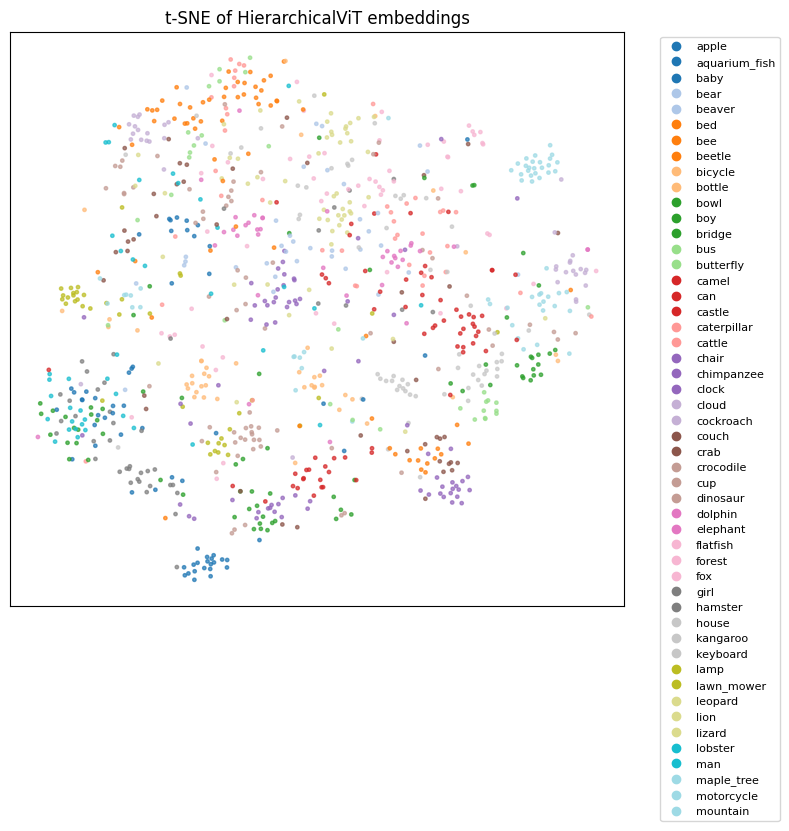

In [ ]:
from validation.tsne_clases import *

feats, labs = collect_features(
    model,
    test_loader,
    device=device,
    max_samples=2000,
    autocast_dtype="fp16",
    use_amp=True,)


from torchvision import datasets
cifar100_train = datasets.CIFAR100(root="./data/cifar100", train=True, download=False)
class_names = cifar100_train.classes

subset_classes = [i for i in range(50)]

tsne_plot(
    feats,
    labs,
    class_names=class_names,
    num_points=2000,
    subset_classes=subset_classes)

Predicciones para: https://floristerialoscolores.com/wp-content/uploads/2023/05/girasol2-1024x788.jpg

      sunflower: 99.98%
          poppy:  0.01%
          tulip:  0.01%
            bee:  0.00%
          shrew:  0.00%


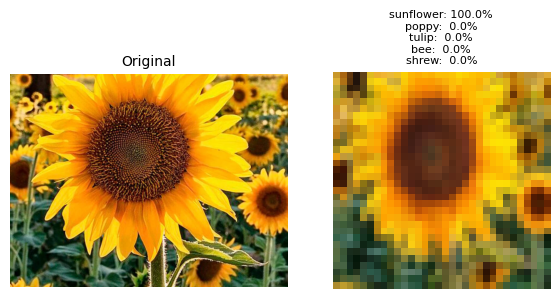

In [ ]:
from validation.url_predict import *


url = "https://floristerialoscolores.com/wp-content/uploads/2023/05/girasol2-1024x788.jpg"

topk_idxs, topk_vals, img_pil, x = predict_from_url(
    model,
    url,
    class_names=class_names,
    device=device,
    autocast_dtype="fp16",
    use_amp=True,)

show_url_prediction_pair(
    img_pil=img_pil,
    x_tensor_norm=x,
    topk_idxs=topk_idxs,
    topk_vals=topk_vals,
    class_names=class_names,)

Predicciones para: https://compumuebles.com/cdn/shop/files/Silla_Verona_Fija_700x700.png?v=1746474880

          couch: 95.19%
          table:  3.63%
         forest:  0.46%
         cattle:  0.28%
           lamp:  0.08%


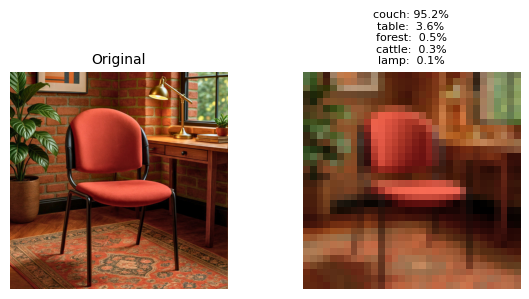

In [ ]:


url = "https://compumuebles.com/cdn/shop/files/Silla_Verona_Fija_700x700.png?v=1746474880"

topk_idxs, topk_vals, img_pil, x = predict_from_url(
    model,
    url,
    class_names=class_names,
    device=device,
    autocast_dtype="fp16",
    use_amp=True,)

show_url_prediction_pair(
    img_pil=img_pil,
    x_tensor_norm=x,
    topk_idxs=topk_idxs,
    topk_vals=topk_vals,
    class_names=class_names)